<a href="https://colab.research.google.com/github/PsorTheDoctor/microarray-data/blob/main/notebooks/microarray_wgan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP: Generowanie mikromacierzy

##Import bibliotek


In [2]:
!git clone https://github.com/PsorTheDoctor/microarray-data.git
%cd microarray-data/

Cloning into 'microarray-data'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 143 (delta 45), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (143/143), 3.37 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/microarray-data


In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from utils.load_data import load_data_by_label
from utils.augmentation import *

##Przygotowanie danych

In [51]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 512

noise_dim = 128

(X_train, X_test) = load_data_by_label(label=0)
X = np.concatenate((X_train, X_test))

print(f'Number of examples: {len(X)}')
print(f'Shape of the images in the dataset: {X.shape[1:]}')

X = X.reshape(X.shape[0], *IMG_SHAPE).astype('float32')
# X_train = (X_train - 127.5) / 127.5

Number of examples: 586
Shape of the images in the dataset: (32, 32)


##Budowa dyskryminatora

In [5]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def build_discriminator():
    img_input = layers.Input(shape=IMG_SHAPE)

    x = conv_block(
        img_input,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

d_model = build_discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)       

## Create the generator


In [6]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # W tym momencie mamy wyjście w kształcie wejścia (32, 32, 1).
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

## Budowa modelu WGAN-GP

In [14]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ 
        Strata jest liczona na obrazie interpolowanym 
        i dodawana do straty dyskryminatora.
        """
        # Pobranie obrazu interpolowanego
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Pobranie wyjścia dyskryminatora dla obrazu interpolowanego
            pred = self.discriminator(interpolated, training=True)

        # 2. Obliczenie gradientów do obrazu interpolowanego
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Obliczenie normy gradientów
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Wygenerowanie fałszywych obrazów
                fake_images = self.generator(random_latent_vectors, training=True)
                # Pobranie logitów dla fałszywych obrazów
                fake_logits = self.discriminator(fake_images, training=True)
                # Pobranie logitów dla rzeczywistych obrazów
                real_logits = self.discriminator(real_images, training=True)

                # Obliczenie straty dyskryminatora przy użyciu logitów
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Obliczenie GP
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Dodanie GP do straty dyskryminatora
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Aktualizacja wag dyskryminatora przy użyciu optymalizatora
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Trening generatora

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Wygenerowanie fałszywych obrazów 
            generated_images = self.generator(random_latent_vectors, training=True)
            # Pobranie logitów dyskryminatora dla fałszywych obrazów
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Obliczenie straty generatora
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Aktualizacja wag generatora przy użyciu optymalizatora
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## Callback

In [ ]:
# class GANMonitor(keras.callbacks.Callback):
#     def __init__(self, num_img=6, latent_dim=128):
#         self.num_img = num_img
#         self.latent_dim = latent_dim

#     def on_epoch_end(self, epoch, logs=None):
#         random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images = (generated_images * 127.5) + 127.5

#         for i in range(self.num_img):
#             img = generated_images[i].numpy()
#             img = keras.preprocessing.image.array_to_img(img)
#             img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

## Trening modelu


In [11]:
# Optymalizator dla obu sieci
# (zalecane są: learning_rate=0.0002, beta_1=0.5)
optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Deklaracja fukncji strat dla dyskryminatora,
# która powinna być różnicą (fake_loss - real_loss).
# GP zostanie dodany do funckji straty później
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Deklaracja fukncji strat dla generatora
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Instantiate the customer `GANMonitor` Keras callback.
# cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=optimizer,
    g_optimizer=optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

In [ ]:
history = wgan.fit(X, batch_size=BATCH_SIZE, epochs=100, verbose=2)

In [ ]:
# from IPython.display import Image, display

# display(Image("generated_img_0_19.png"))
# display(Image("generated_img_1_19.png"))
# display(Image("generated_img_2_19.png"))

Text(0, 0.5, 'Strata')

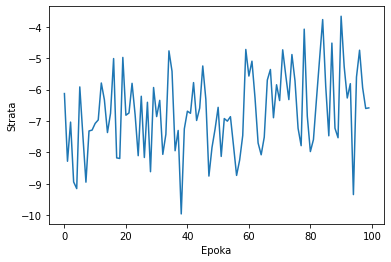

In [53]:
plt.plot(history.history['d_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

Text(0, 0.5, 'Strata')

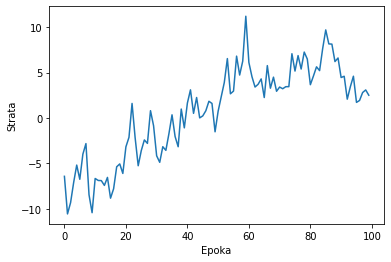

In [55]:
plt.plot(history.history['g_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

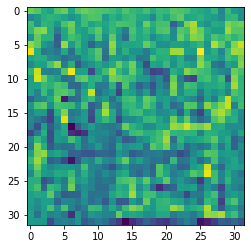

In [56]:
num_img = 1
latent_dim = 128

random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
generated_images = g_model(random_latent_vectors)
# generated_images = (generated_images * 127.5) + 127.5

# for i in range(num_img):
#   img = generated_images[i].numpy()
#   img = keras.preprocessing.image.array_to_img(img)

res = np.array(generated_images[0]).reshape((32, 32))

plt.imshow(res, cmap='viridis')